# Supervised learning of SNN with pruning on    
# 'unfamiliar blurred random images'

In [1]:
import os
import torch
import torch.nn as nn
from torch import Tensor
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
from collections import Counter

from brian2 import *

import brian2.numpy_ as np

from keras.datasets import mnist

import copy
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import time
import pandas as pd
import operator
import random
import numbers

from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

INFO       Cache size for target "cython": 2837 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/dmitry/.cython/brian_extensions" directory. [brian2]


## Data sets

In [2]:
class Transform:
    
    def __init__(self, PIL_type=False):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        
    def __call__(self, image):
        if self.PIL_type:
            image = self.to_pil_image(image)
        image = self.to_tensor(image)
        #image.squeeze_(0)

        return image

In [3]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [4]:
classes = [7, 4, 6]

max_classes = 10
img_size = 28*28 # input image size

### Set 0

In [5]:
# number of image in each class
train_limit = 5000                         
test_limit = 500

# The MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'     

for ind in classes: 
    globals()[f'train_digit_{ind}_images'] = torch.load(f'{path}train_images_{ind}.pt', 
                                                      map_location=torch.device('cpu'))[0:train_limit]
    globals()[f'train_digit_{ind}_labels'] = torch.load(f'{path}train_labels_{ind}.pt', 
                                                      map_location=torch.device('cpu'))[0:train_limit]
    globals()[f'test_digit_{ind}_images'] = torch.load(f'{path}test_images_{ind}.pt', 
                                                     map_location=torch.device('cpu'))[0:test_limit]
    globals()[f'test_digit_{ind}_labels'] = torch.load(f'{path}test_labels_{ind}.pt', 
                                                     map_location=torch.device('cpu'))[0:test_limit]

train_MNIST_labels = globals()[f'train_digit_{classes[0]}_labels']
train_MNIST_images = globals()[f'train_digit_{classes[0]}_images']
test_MNIST_labels = globals()[f'test_digit_{classes[0]}_labels']
test_MNIST_images = globals()[f'test_digit_{classes[0]}_images']                                 

for ind in classes[1:]:
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{ind}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{ind}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{ind}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{ind}_images']), 0)
    
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

# decrease of pixel intensity (255 becomes ~63)

train_MNIST_images = train_MNIST_images.squeeze(1)/4
test_MNIST_images = test_MNIST_images.squeeze(1)/4

# Loaders

transform_PIL = Transform(PIL_type=True)

train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), 
                                      transform=transform_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), 
                                     transform=transform_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set)) 
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set)) 

train_MNIST_images.size(), test_MNIST_images.size()

(torch.Size([15000, 28, 28]), torch.Size([1500, 28, 28]))

### Set 1

In [6]:
classes_1 = [9, 2, 1]

#class_coeff = int(len(classes)/len(classes_1))

number_blure_random = 16500 #number of randomized images in handmade set

randomized_images = torch.rand([number_blure_random, 28, 28], dtype=torch.float) 
randomized_images = gaussian_filter(randomized_images, sigma=2)

# normalize image to (0,1) range
randomized_images -= np.amin(randomized_images[:])
randomized_images /= np.amax(randomized_images[:])

randomized_images = torch.from_numpy(randomized_images)
randomized_labels = torch.ones((number_blure_random, ), dtype=int)

# saving data
path_blure_random = f'./data/blurred_random_images/'

if not (os.path.exists(path_blure_random) and os.path.isdir(path_blure_random)):
    os.makedirs(path_blure_random)
    
torch.save(randomized_labels, f'{path_blure_random}blur_random_labels.pt')
torch.save(randomized_images, f'{path_blure_random}blur_random_images.pt')

# split
blure_random_image_train, blure_random_image_test, blure_random_label_train, blure_random_label_test = \
train_test_split(randomized_images, randomized_labels, test_size=test_limit/(test_limit+train_limit), random_state=42)

blure_random_image_train = blure_random_image_train[0:train_limit*len(classes_1)]
blure_random_label_train = blure_random_label_train[0:train_limit*len(classes_1)]
blure_random_image_test = blure_random_image_test[0:test_limit*len(classes_1)]
blure_random_label_test = blure_random_label_test[0:test_limit*len(classes_1)]

# divider of intencity

MNIST_intencity = train_MNIST_images.reshape(len(train_MNIST_images), 28*28).sum(1).sum(0)/len(train_MNIST_images)
blure_random_intencity = blure_random_image_train.reshape(len(blure_random_image_train), 28*28).sum(1).sum(0)/len(blure_random_image_train)
divider_intencity = blure_random_intencity/MNIST_intencity

print(f'divider of intencity = {divider_intencity :.1f}')

blure_random_image_train = blure_random_image_train/divider_intencity #16  # decreasing of pixel intensity to the 'MNIST set' level
blure_random_image_test = blure_random_image_test/divider_intencity   #16  # decreasing of pixel intensity to the 'MNIST set' level

# transformation of label sets 
blure_random_label_train = torch.Tensor([classes_1[0]]*train_limit)
blure_random_label_test = torch.Tensor([classes_1[0]]*test_limit)                                 

if len(classes_1) > 1:
    for i in classes_1[1:]:
        blure_random_label_train = torch.cat((blure_random_label_train, torch.Tensor([i]*train_limit)), 0)
        blure_random_label_test = torch.cat((blure_random_label_test, torch.Tensor([i]*test_limit)), 0)

# Loaders

transform_PIL = Transform(PIL_type=True)

blure_random_image_train_set = CustomTensorDataset(tensors=(blure_random_image_train, blure_random_label_train), 
                                      transform=transform_PIL)
blure_random_image_test_set = CustomTensorDataset(tensors=(blure_random_image_test, blure_random_label_test), 
                                     transform=transform_PIL)

train_blure_random_loader = DataLoader(blure_random_image_train_set, batch_size=len(blure_random_image_train_set)) 
test_blure_random_loader = DataLoader(blure_random_image_test_set, batch_size=len(blure_random_image_test_set)) 

blure_random_image_train.size(), blure_random_image_test.size()

divider of intencity = 16.2


(torch.Size([15000, 28, 28]), torch.Size([1500, 28, 28]))

## Initial data

In [7]:
pixels_row = 28
n_input = pixels_row*pixels_row # input layer

# Setting 10 neurons per class

# common data
taupre = 20*ms
taupost = taupre
time_ext = 5*len(classes)*500*ms 

# 1-st set - Net0
n_e = 10*len(classes) # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

dApre = .01
dApost = -dApre * taupre / taupost * 1.05
gmax = 0.05 
dApost *= gmax
dApre *= gmax

# 2-nd set - Net1
n_ee = int(n_e/max_classes)*len(classes) # e - excitatory
n_ii = n_ee                              # i - inhibitory

vv_rest_e = -60.*mV   # v - membrane potential
vv_reset_e = -65.*mV
vv_thresh_e = -52.*mV 

vv_rest_i = -60.*mV
vv_reset_i = -45.*mV
vv_thresh_i = -40.*mV

dApre1 = .01
dApost1 = -dApre1 * taupre / taupost * 1.05
gmax1 = gmax*50   
dApost1 *= gmax1
dApre1 *= gmax1
test_stop = 1
tpre = 0   
tpost = 0  

w0 = 1
wi = 3 # strength of inhibitory synapse in Net0
wii = 3 # strength of inhibitory synapse in Net1

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
# stdp0, pre0, post0 for S1 

stdp0='''w : 1
    lr1 : 1
    lr2 : 1
    test_stop : 1
    tpre : second
    tpost : second
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''

pre0='''
    w = exp(-((t-tpre)*test_stop/time_ext)**2)*w
    ge += w
    Apre += dApre
    w = clip(w + lr1*Apost, 0, gmax)
    tpre = t'''

post0='''Apost += dApost
    w = clip(w + lr2*Apre, 0, gmax)
    tpost = t'''

## Models

In [8]:
class Model0():

    def __init__(self, debug=False):
        app0 = {}       
        
        # NEURON LAYERS
        # input images as rate encoded Poisson generators
        app0['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')    
        
        # excitatory group (WITH ADAPTIVE THRESHOLD)
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dvt/dt = (v_thresh_e-vt)/(150*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            v2 : volt
            '''         
        
        reset_e = '''
        v = v_reset_e
        vt += 3*mV
        '''
        app0['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v2', refractory=5*ms, 
                                reset=reset_e, method='euler', name='EG')
        
        for cl in range(len(classes)):           
            app0[f'EG_{cl}'] = Subgroup(app0['EG'], cl*10, (cl+1)*10, name=f'EG_{cl}')
            app0[f'EG_{cl}'].v = v_rest_e - 20.*mV     
            app0[f'EG_{cl}'].vt = v_thresh_e   
            app0[f'EG_{cl}'].v2 = v_thresh_e  

        # inhibitory group
        neuron_i = '''
                    dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
                    dge/dt = -ge / (5*ms) : 1
                    '''
        app0['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, 
                                reset='v=v_reset_i', method='euler', name='IG')
        app0['IG'].v = v_rest_i - 20.*mV
       
        # SYNAPSES
        # poisson generators one-to-all excitatory neurons with plastic connections
        for cl in range(len(classes)):
            # we should have a possibility to independently change learning rate for every class subgroup
            app0[f'S1_{cl}'] = Synapses(app0['PG'], app0['EG'][cl*10:(cl+1)*10], stdp0, 
                                       on_pre=pre0, on_post=post0, method='euler', name=f'S1_{cl}')
            app0[f'S1_{cl}'].connect()
            app0[f'S1_{cl}'].w = 'rand()*gmax' # random weights initialisation
            app0[f'S1_{cl}'].lr1 = 1 # enable stdp
            app0[f'S1_{cl}'].lr2 = 1 # enable stdp
            
        # excitatory neurons one-to-one inhibitory neurons
        app0['S2'] = Synapses(app0['EG'], app0['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app0['S2'].connect(j='i')
        app0['S2'].delay = 'rand()*10*ms'
        app0['S2'].w = wi # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app0['S3'] = Synapses(app0['IG'], app0['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app0['S3'].connect(condition='i!=j')
        app0['S3'].delay = 'rand()*5*ms'
        app0['S3'].w = wi/n_e # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net0 = Network(app0.values())
        self.net0.run(0*second)

    def __getitem__(self, key):
        return self.net0[key]
                
    def train_supervised(self, data, targets):        
        
        for idx in range(len(data)):
            
            yt = int(targets[idx])             # target class    
            
            for cl in range(len(classes)):           
                    self.net0[f'EG_{cl}'].v2 = 'vt'
       
            # set learning rate for each subgroup of excitatory neurons
            for cl in range(len(classes)): 
                
                # Learning rate (lr1, lr2) values for S1
                if cl == classes.index(yt):  
                    self.net0[f'S1_{cl}'].lr1 = 1  # canonical STDP
                    self.net0[f'S1_{cl}'].lr2 = 1
                else:
                    self.net0[f'S1_{cl}'].lr1 = 1  # all-LTD 
                    self.net0[f'S1_{cl}'].lr2 = -1
            
            # active mode 
            self.net0['PG'].rates = data[idx].ravel()*Hz 
            self.net0.run(0.35*second)

            # passive mode         
            self.net0['PG'].rates = np.zeros(n_input)*Hz
            self.net0.run(0.15*second)               
            
            if idx%100 == 0: 
                print(f'- {idx+1} have already been processed')
            
        wts_0 = np.concatenate((np.array(self.net0['S1_0'].w), \
                np.array(self.net0['S1_1'].w), np.array(self.net0['S1_2'].w)), axis=0)
        weight_picture(wts_0)
                
        self.net0['PG'].rates = torch.ones(n_input, dtype=torch.float).numpy()*63.0*Hz 
        for cl in range(len(classes)):
            self.net0[f'S1_{cl}'].lr1 = 0 
            self.net0[f'S1_{cl}'].lr2 = 0
            self.net0[f'S1_{cl}'].test_stop = 1
        self.net0.run(0.05*second)
            
    def evaluate(self, data, targets, different_classes):
        
        for cl in range(len(classes)):                           # adaptive threshold    
            self.net0[f'EG_{cl}'].v2 = v_thresh_e

        for cl in range(len(classes)):
            self.net0[f'S1_{cl}'].lr1 = 0  # turn off learning
            self.net0[f'S1_{cl}'].lr2 = 0  # turn off learning
            self.net0[f'S1_{cl}'].test_stop = 0
        
        # spike counts for every group
        cols = ['0', '1', '2', 'TRUE', 'true_class', 'recogn_class', 'unrecogn']        
        counts = pd.DataFrame(columns=cols) 
        artefact_image = []            

        for idx in range(len(data)):   
                    
            yt = int(targets[idx])     # target class  

            # rate monitor to count spikes
            mon = SpikeMonitor(self.net0['EG'], record=True, name='RM')
            self.net0.add(mon)

            # active mode               
            self.net0['PG'].rates = data[idx].ravel()*Hz 
            self.net0.run(0.35*second)
        
             # calculate spike count for every group of excitatory neurons            
            for cl in range(len(different_classes)): 
                counts.loc[idx, f'{cl}'] = sum(mon.count[cl*10:(cl+1)*10]) 

            counts.loc[idx, 'true_class'] = different_classes.index(yt)
            
            if len(self.net0['RM'].i) > 0:                 
                mx = counts[['0', '1', '2']].eq(counts.max(axis=1), axis=0).loc[idx]
                
                if len(mx[mx == True]) > 0:
                    try:
                        counts.loc[idx, 'recogn_class'] = int(mx[mx == True].index[0])
                    except ValueError:
                        counts.loc[idx, 'recogn_class'] = len(different_classes)
                else:
                    counts.loc[idx, 'recogn_class'] = len(different_classes)
                    artefact_image.append(idx)
                
                counts.loc[idx, 'unrecogn'] = 0
                               
                # check the correctness of prediction                   
                if int(counts['recogn_class'].loc[idx]) == different_classes.index(yt): 
                    counts.loc[idx, 'TRUE'] = 1                                        
                else:
                    counts.loc[idx, 'TRUE'] = 0
                             
            else:
                counts.loc[idx, 'TRUE'] = 0
                counts.loc[idx, 'recogn_class'] = 0
                counts.loc[idx, 'unrecogn'] = 1
        
            # passive mode
            self.net0['PG'].rates = np.zeros(n_input)*Hz
            self.net0.run(0.15*second)
            
            self.net0.remove(self.net0['RM'])
            
        if len(artefact_image) > 0:
            print(f'Artefact in {artefact_image} images:') 
            print(*artefact_image)
            
        return counts 

In [9]:
def weights_picture(wts_0):
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=300, constrained_layout=True) 

    fig.set_figheight(3)
    fig.set_figwidth(12)

    ax.set_xlim(left=0.0, right=n_input*n_e*1.01)
    ax.set_ylim(bottom=0, top=gmax*1.1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(5000))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(gmax/5))

    ax.set_xlabel(r"synapse number", loc='center', fontsize=14, fontfamily='serif')
    ax.set_ylabel(r'weight value',  loc='center', fontsize=14, fontfamily='serif')

    ax.xaxis.set_tick_params(which='major', size=5, width=0.5, labelsize = 14, direction='out')
    ax.yaxis.set_tick_params(which='major', size=5, width=0.5, labelsize = 14, direction='out')

    ax.plot(np.arange(len(wts_0)), wts_0, '.b', markersize=5, marker = '.');

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fig.set(facecolor='w')

    fig.tight_layout()

## Models activation

In [10]:
model0 = Model0()

model0.net0.restore('model0','saved_model0_pruned.b2')

WARNING    "i" is an internal variable of group "S2", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "S3", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "test_stop" is an internal variable of group "S1_0", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "tpre" is an internal variable of group "S1_0", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "test_stop" is an internal variable of group "S1_1", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group

## Training of S1

## Synapse weights

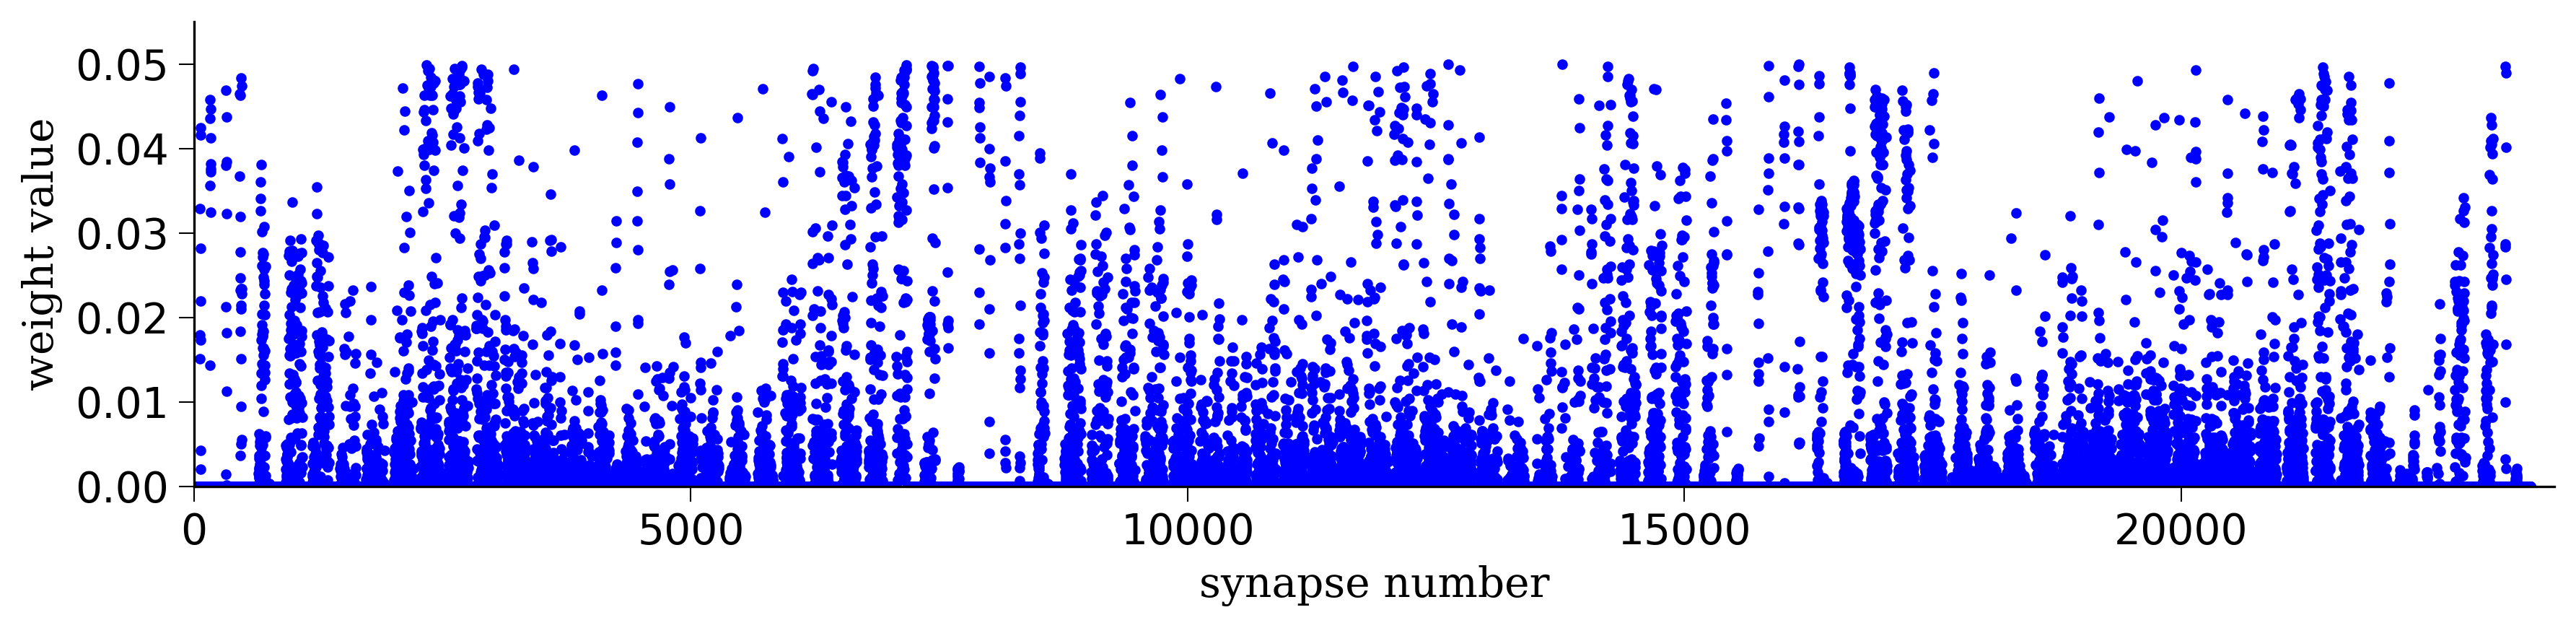

In [11]:
wts_0 = np.concatenate((np.array(model0.net0['S1_0'].w), \
                          np.array(model0.net0['S1_1'].w), np.array(model0.net0['S1_2'].w)), axis=0)

weights_picture(wts_0)

## Test

In [12]:
start = time.time()

print('Testing on unfamiliar blurred random test set')
        
for data, targets in test_blure_random_loader:   

    data = data.squeeze(1)
    targets = np.array(targets.numpy(), dtype=uint8)

    for i in range(len(data)):   
        data_n = data[i].numpy().ravel()*256
        if i == 0:
            data_np = data_n
        else:
            data_np = np.vstack((data_np, data_n))  

    counts_0 = model0.evaluate(data_np, targets, classes_1)

end = time.time()
print(f'Processing time: {int((end - start)//60)} min {int((end - start)%60)} sec')

Testing on unfamiliar blurred random test set
Artefact in [1024, 1070, 1078, 1096, 1173, 1191, 1272, 1402, 1414, 1438] images:
1024 1070 1078 1096 1173 1191 1272 1402 1414 1438
Processing time: 69 min 43 sec


In [13]:
counts_0['Total'] = counts_0.loc[:,['0', '1', '2']].sum(axis=1)
counts_0.loc['Total',:] = counts_0.sum(axis=0)
print(f"Accuracy of unfamiliar blurred random set recognition = {counts_0.loc['Total','TRUE']/(len(counts_0.index)-1)*100 :.1f}%")

Accuracy of unfamiliar blurred random set recognition = 0.7%


In [14]:
counts_0.loc['Total']

0                 33
1                  0
2                  2
TRUE              10
true_class      1500
recogn_class      32
unrecogn        1469
Total             35
Name: Total, dtype: object

## Different synapse sets 

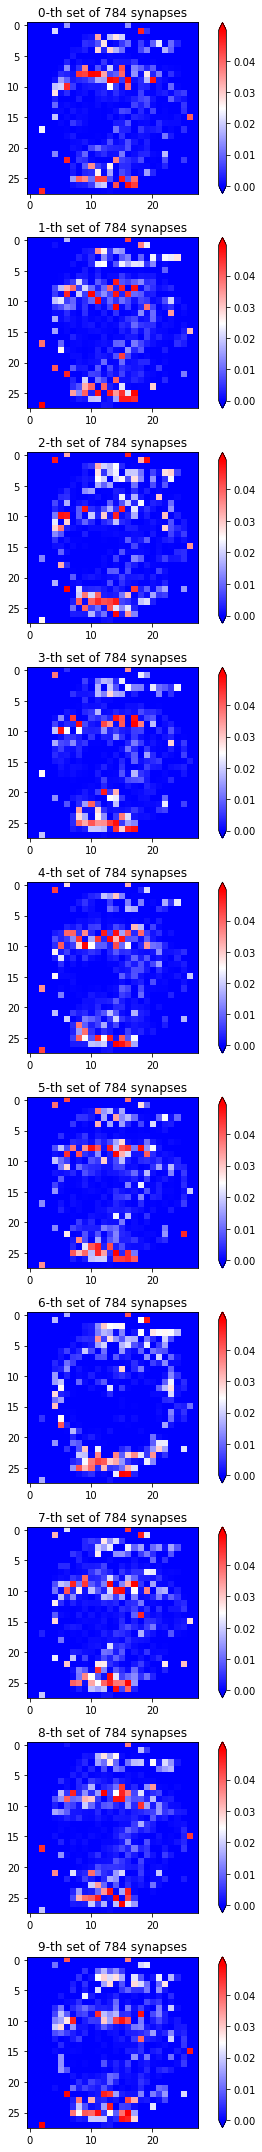

In [15]:
# first set

fig, axs = plt.subplots(int(n_e/3), 1, figsize=(6, n_e), sharey=True, tight_layout=True) 

for i in range(int(n_e/3)):
    data = model0.net0['S1_0'].w[:, i].reshape(28,28)
    picture = axs[i].imshow(data, cmap='bwr', interpolation='none');
    fig.colorbar(picture, ax=axs[i], extend='both');
    axs[i].set_title(f'{i}-th set of 784 synapses')
    
    fig.show()

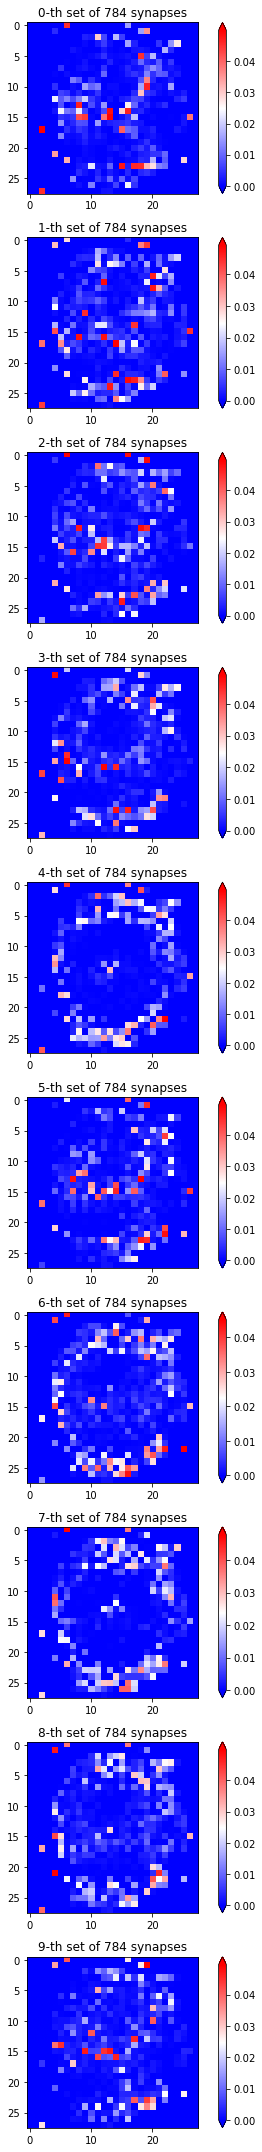

In [16]:
# second set

fig, axs = plt.subplots(int(n_e/3), 1, figsize=(6, n_e), sharey=True, tight_layout=True) 

for i in range(int(n_e/3)):
    data = model0.net0['S1_1'].w[:, i].reshape(28,28)
    picture = axs[i].imshow(data, cmap='bwr', interpolation='none');
    fig.colorbar(picture, ax=axs[i], extend='both');
    axs[i].set_title(f'{i}-th set of 784 synapses')
    
    fig.show()

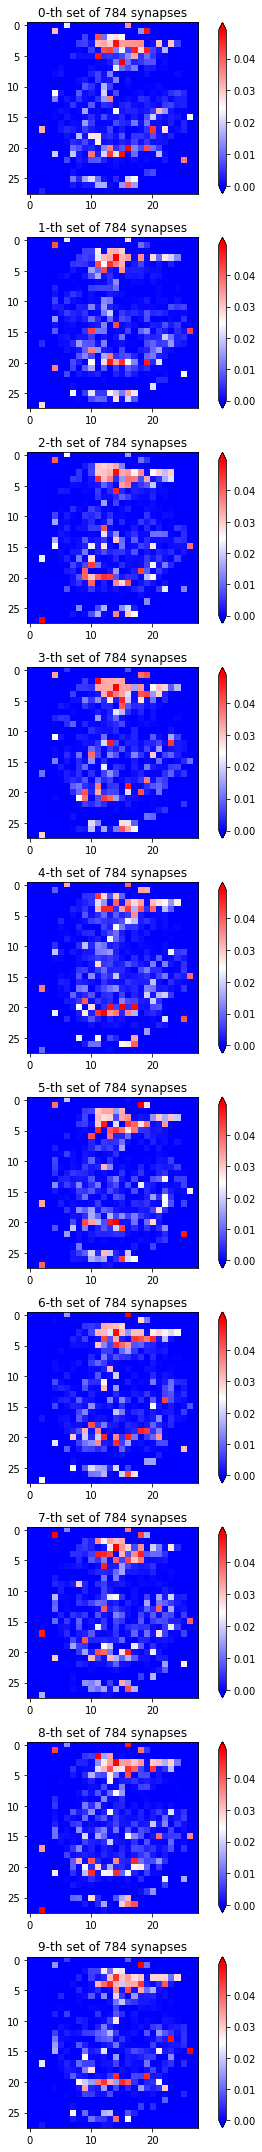

In [17]:
#third set

fig, axs = plt.subplots(int(n_e/3), 1, figsize=(6, n_e), sharey=True, tight_layout=True) 

for i in range(int(n_e/3)):
    data = model0.net0['S1_2'].w[:, i].reshape(28,28)
    picture = axs[i].imshow(data, cmap='bwr', interpolation='none');
    fig.colorbar(picture, ax=axs[i], extend='both');
    axs[i].set_title(f'{i}-th set of 784 synapses')
    
    fig.show()